# SERGAS data analysis - times scans

author: JAH, JJG

version: 15/06/20


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Wed Jun 17 17:11:43 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

from scipy import stats

import c19.useir     as us
import c19.useir_ana as usa

In [4]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
from c19.data_functions_HG import hg_get_data_ingresos, hg_get_data_pacientes, hg_get_data_age
from c19.HG_analysis import plot_hgi, plot_nh_nu, recovery_time, exitus_time, exitus_group, exitus, hosp_uci, select_age_by_CA_and_sex
from c19.HG_analysis import hist_XY_series, plot_XY_series, plot_pop_age
from c19.HG_analysis import formatter

In [6]:
datapath="/Users/hernando/investigacion/bio/c19/data/HospitalesGalicia"
file = "IngresosCovid.csv"
filep = "PacientesCOVID.csv"
ff =f'{datapath}/{file}'
fp =f'{datapath}/{filep}'
dfi = pd.read_csv(ff, sep='|')

## HGalicia

In [7]:
def get_cases(df, index = 'ingreso'):
    nps = df.groupby([index]).pacienteID.count()
    sel = nps.index >= np.datetime64('2020-02-15')
    dates, cases = nps.index[sel], nps.values[sel]
    return dates, cases

def get_deaths(dfp, code = 'EXITUS'):
    sel = (dfp.code == 'EXITUS') & (dfp.alta.values >= np.datetime64('2020-02-01'))
    dfe = dfp[sel] 
    nps = dfe.groupby(['alta']).pacienteID.count()
    dates, cases = nps.index, nps.values
    return dates, cases

def plot_cases(dates, cases, title = ''):
    plt.figure(figsize = (8, 6))
    plt.errorbar(dates, cases, yerr = np.maximum(np.sqrt(cases), 2.4), 
                 ls = '', marker = 'o', ms = 4)
    formatter(plt.gca());

In [8]:
hgi = hg_get_data_ingresos(ff)
hgi.head()

,pacienteID,ingreso,alta,hosp
0,8,2020-03-18,2020-03-26,HOS
1,9,2020-03-29,2020-04-24,HOS
2,10,2020-03-27,2020-04-07,HOS
3,10,2020-04-14,2020-04-30,HOS
4,12,2020-03-23,2020-04-09,HOS


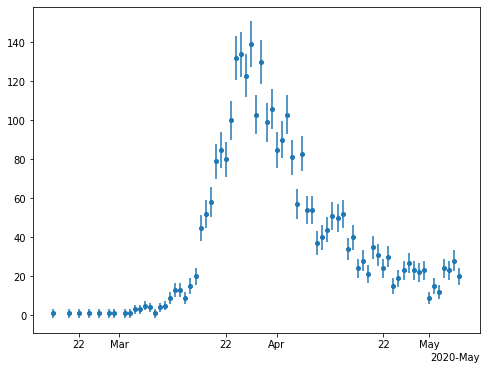

In [9]:
dates, cases = get_cases(hgi)
plot_cases(dates, cases, 'cases');

## Cases

### fit - code

In [10]:
nn = {'Madrid': 6578079, 'Castilla y Leon': 2409164, 'Castilla La Mancha': 2026807, 
      'Cataluna': 7600065, 'C. Valenciana': 4963703, 'Aragon': 1308728, 'Pais Vasco': 2199088, 
      'Navarra': 647554, 'La Rioja': 315675, 'Cantabria': 580229, 'Asturias': 1028244, 
      'Galicia': 2701743, 'Murcia': 1478509, 'Andalucia': 8384408, 'Extremadura': 1072863, 
      'Baleares': 1128908, 'Canarias': 2127685}

n0  = nn['Galicia']

In [46]:
TR, TI = 2.7, 5.

best   = False
masks0 =  2 * (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))
masks1 =  2 * (('t0', 'phi'), ('phi', 'beta', 'gamma'))
masks2 =  2 * (('t0',), ('beta', 'gamma')) 

#masks0 = masks1

def kpars0(tr = TR, ti = TI):
    kpars =  {'t0': 15.0 + 2. * tr, 'beta': 4/tr, 'gamma': 0.60/tr, 'tr': tr, 'ti': ti, 
              'n': n0, 'phi': 0.1, 's1': 0.005 + 0.015 * (tr / 20)}
    if (best):
        kpars = {'t0': 21.452184562257216, 'beta': 1.4063281481696, 'gamma': 0.21617241616035102, 'tr': tr, 
         'ti': ti, 'n': 2701743.0, 'phi': 0.035, 's1': 0.015}
    return kpars

def fit(dates, cases, masks = masks0, tr = TR, ti = TI, ffit = 'chi2'):
    kpars = kpars0(tr, ti)
    for imask in masks:
        kpars, fval = usa.useirqr_fit(dates, cases, kpars = kpars, kmask = imask, ffit = ffit)
    kpars[ffit] = fval
    return kpars

def fit_scan(dates, cases, masks = masks0, trs = (TR,), tis = (TI,), ffit = 'chi2'):
    dpars = []
    tbar = IntProgress(0, max = len(trs) * len(tis), description = 'fitting...'); 
    display(tbar); tbar.value = 1
    for ti in tis:
        for tr in trs:
            tbar.value += 1
            kpars = fit(dates, cases, masks, tr = tr, ti = ti, ffit = ffit)
            dpars.append(kpars.copy())                
    return dpars

def plot_fit(dates, cases, kpars):
    mpars = kpars.copy(); 
    if 'chi2' in mpars.keys(): mpars.pop('chi2')
    fmodel = usa.useirqr_fmodel(kpars = mpars)
    usa.plot_data_model(dates, cases, fmodel)
    return

def to_df(dpars):
    nsize = len(dpars)
    keys = dpars[0].keys()
    dat = {}
    for key in keys:
        dat[key] = np.array([dpar[key] for dpar in dpars])
    df = pd.DataFrame(dat)
    return df


### cases initial seed

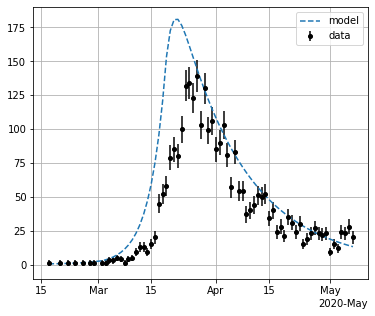

In [12]:
plot_fit(dates, cases, kpars0())

### Fit

{'t0': 17.478338467420258, 'beta': 1.4813611683500412, 'gamma': 0.22274236290139598, 'tr': 2.7, 'ti': 5.0, 'n': 2701743.0, 'phi': 0.06794475121769988, 's1': 0.0070894989892696485, 'chi2': 141.48659581087549}


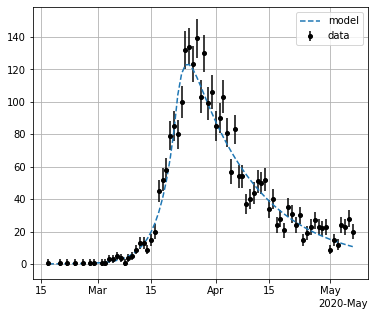

In [13]:
kpars = fit(dates, cases)
plot_fit(dates, cases, kpars)
print(kpars)

### TIs scan

In [47]:
def ana_tis_scan(tis, masks):
    print('Ti scan : ', tis)
    print('masks   : ', masks)
    kpars = fit_scan(dates, cases, masks, tis = tis)
    dpars = to_df(kpars)
    print(dpars)
    ibest = np.argmin(dpars['chi2'].values)
    plot_fit(dates, cases, kpars[ibest]); plt.legend('');
    plt.figure(figsize = (6, 5))
    plt.plot(dpars['ti'], dpars['chi2'] - np.min(dpars['chi2']));
    plt.grid(); plt.title(r'$\Delta \chi^2$'); plt.xlabel(r'$T_i$');
    return dpars

def ana_trs_scan(trs, masks):
    print('Tr scan : ', trs)
    print('masks   : ', masks)
    kpars = fit_scan(dates, cases, masks, trs = trs)
    dpars = to_df(kpars)
    print(dpars)
    ibest = np.argmin(dpars['chi2'].values)
    plot_fit(dates, cases, kpars[ibest]); plt.legend('');
    plt.figure(figsize = (6, 5))
    plt.plot(dpars['tr'], dpars['chi2'] - np.min(dpars['chi2']));
    plt.grid(); plt.title(r'$\Delta \chi^2$'); plt.xlabel(r'$T_r$');
    return dpars

Ti scan :  [4.   4.25 4.5  4.75 5.   5.25 5.5  5.75]
masks   :  (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'), ('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))


IntProgress(value=0, description='fitting...', max=8)

          t0      beta     gamma   tr    ti          n       phi        s1  \
0  12.628088  1.515136  0.237398  2.7  4.00  2701743.0  0.059781  0.007338   
1  14.776946  1.469918  0.234076  2.7  4.25  2701743.0  0.061980  0.007119   
2  15.449783  1.473765  0.230233  2.7  4.50  2701743.0  0.064195  0.007181   
3  16.632378  1.477654  0.226435  2.7  4.75  2701743.0  0.066164  0.007199   
4  17.478338  1.481361  0.222742  2.7  5.00  2701743.0  0.067945  0.007089   
5  18.493637  1.485120  0.219068  2.7  5.25  2701743.0  0.069497  0.007171   
6  19.776558  1.488687  0.215478  2.7  5.50  2701743.0  0.070885  0.007229   
7  22.807314  1.397316  0.202917  2.7  5.75  2701743.0  0.068401  0.007066   

         chi2  
0  147.762766  
1  142.989588  
2  141.628634  
3  141.134663  
4  141.486596  
5  142.660010  
6  144.640487  
7  149.230625  


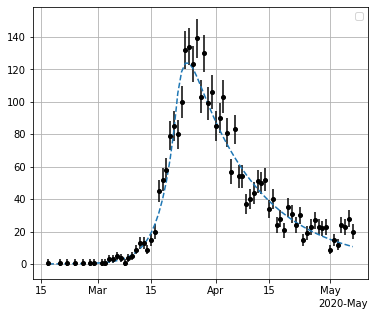

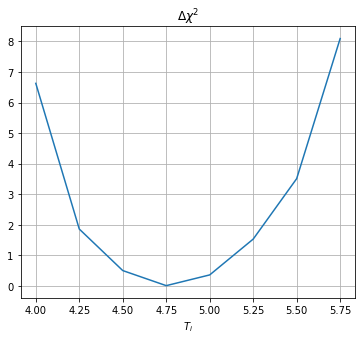

In [40]:
best   = False
tis    = np.linspace(4.0, 5.75, 8)
dpars  = ana_tis_scan(tis, masks0)

Ti scan :  [4.   4.25 4.5  4.75 5.   5.25 5.5  5.75]
masks   :  (('t0', 'phi'), ('phi', 'beta', 'gamma'), ('t0', 'phi'), ('phi', 'beta', 'gamma'))


IntProgress(value=0, description='fitting...', max=8)

          t0      beta     gamma   tr    ti          n       phi        s1  \
0  12.810003  1.453481  0.227839  2.7  4.00  2701743.0  0.067436  0.007025   
1  14.292560  1.459452  0.234059  2.7  4.25  2701743.0  0.065672  0.007025   
2  15.375290  1.464706  0.230225  2.7  4.50  2701743.0  0.067440  0.007025   
3  16.373845  1.499417  0.226431  2.7  4.75  2701743.0  0.058881  0.007025   
4  17.538533  1.518658  0.222704  2.7  5.00  2701743.0  0.055681  0.007025   
5  18.372618  1.521063  0.219187  2.7  5.25  2701743.0  0.057269  0.007025   
6  19.658758  1.523042  0.215549  2.7  5.50  2701743.0  0.058890  0.007025   
7  21.441584  1.482502  0.213381  2.7  5.75  2701743.0  0.060554  0.007025   

         chi2  
0  159.841006  
1  142.744122  
2  141.584162  
3  141.004477  
4  140.698182  
5  141.157921  
6  142.454858  
7  148.460297  


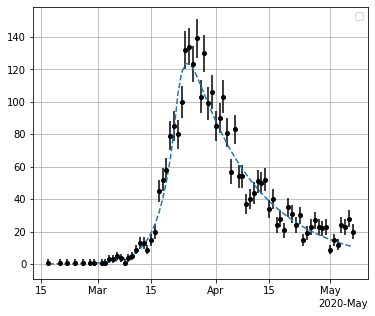

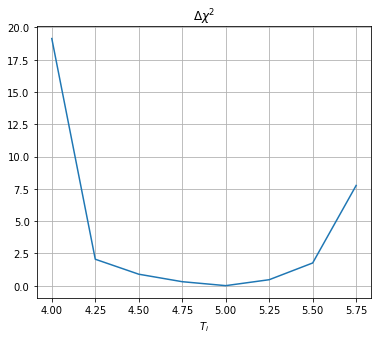

In [41]:
best   = True
tis    = np.linspace(4.0, 5.75, 8)
dpars  = ana_tis_scan(tis, masks1)

Conclusion: $T_i = 5 \pm 0.3$ days

### Tr scan

Notice: We can replace the scan to not fix phi, s1, otherwise is almost flat

Ti scan :  [2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.        ]
masks   :  (('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'), ('t0', 's1', 'phi'), ('s1', 'beta', 'gamma'))


IntProgress(value=0, description='fitting...', max=7)

          t0      beta     gamma        tr   ti          n       phi  \
0  16.677387  1.839708  0.300818  2.000000  5.0  2701743.0  0.046409   
1  15.620843  1.713789  0.257476  2.333333  5.0  2701743.0  0.059081   
2  17.534211  1.499701  0.225692  2.666667  5.0  2701743.0  0.064463   
3  19.251459  1.334008  0.200031  3.000000  5.0  2701743.0  0.067168   
4  21.600752  1.201931  0.178988  3.333333  5.0  2701743.0  0.067802   
5  23.417914  1.094039  0.161404  3.666667  5.0  2701743.0  0.066971   
6  26.581777  1.003732  0.147043  4.000000  5.0  2701743.0  0.053502   

         s1        chi2  
0  0.008086  146.013467  
1  0.007946  142.830439  
2  0.007325  141.446923  
3  0.007022  143.434733  
4  0.007531  148.122706  
5  0.007377  155.054552  
6  0.008786  164.257231  


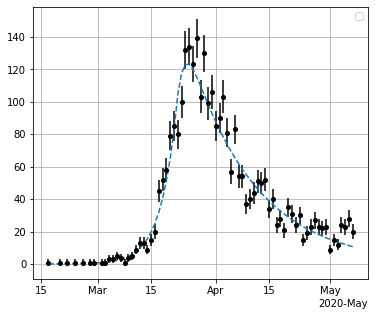

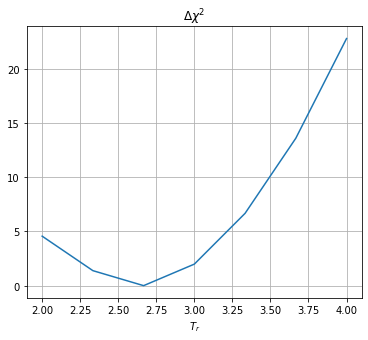

In [42]:
best   = False 
trs    = np.linspace(2., 4., 7)
dpars2 = ana_trs_scan(trs, masks0)

Tr scan :  [2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.        ]
masks   :  (('t0', 'phi'), ('phi', 'beta', 'gamma'), ('t0', 'phi'), ('phi', 'beta', 'gamma'))


IntProgress(value=0, description='fitting...', max=7)

          t0      beta     gamma        tr   ti          n       phi     s1  \
0  28.529989  1.410497  0.290050  2.000000  5.0  2701743.0  0.028803  0.015   
1  25.509036  1.410308  0.257165  2.333333  5.0  2701743.0  0.027586  0.015   
2  22.516561  1.379579  0.219850  2.666667  5.0  2701743.0  0.035053  0.015   
3  21.721910  1.409209  0.202493  3.000000  5.0  2701743.0  0.026870  0.015   
4  20.661075  1.423914  0.188193  3.333333  5.0  2701743.0  0.025588  0.015   
5  20.439132  1.364769  0.168146  3.666667  5.0  2701743.0  0.026382  0.015   
6  19.663570  1.406319  0.159139  4.000000  5.0  2701743.0  0.024947  0.015   

         chi2  
0  162.113164  
1  146.212654  
2  144.214667  
3  140.405477  
4  149.115208  
5  145.049176  
6  165.397256  


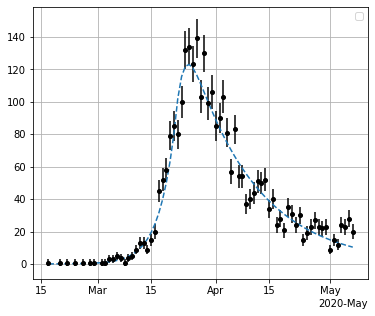

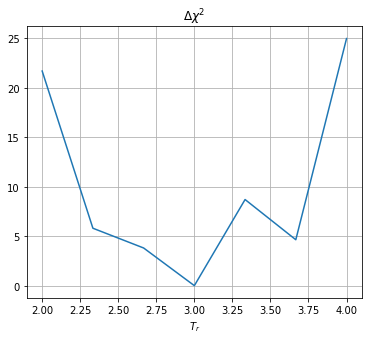

In [49]:
best   = True
trs    = np.linspace(2., 4., 7)
dpars2 = ana_trs_scan(trs, masks1)

Tr scan :  [2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.        ]
masks   :  (('t0',), ('beta', 'gamma'), ('t0',), ('beta', 'gamma'))


IntProgress(value=0, description='fitting...', max=7)

          t0      beta     gamma        tr   ti          n    phi     s1  \
0  28.585036  1.384582  0.289112  2.000000  5.0  2701743.0  0.035  0.015   
1  25.903513  1.379526  0.253473  2.333333  5.0  2701743.0  0.035  0.015   
2  22.524794  1.379730  0.219891  2.666667  5.0  2701743.0  0.035  0.015   
3  21.452185  1.370576  0.199324  3.000000  5.0  2701743.0  0.035  0.015   
4  18.341618  1.469991  0.180761  3.333333  5.0  2701743.0  0.035  0.015   
5  20.379575  1.287887  0.158968  3.666667  5.0  2701743.0  0.035  0.015   
6  19.306966  1.314641  0.149687  4.000000  5.0  2701743.0  0.035  0.015   

         chi2  
0  165.466147  
1  150.536214  
2  144.216194  
3  142.890665  
4  152.966230  
5  140.228290  
6  141.919308  


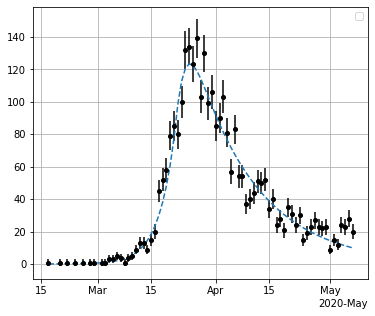

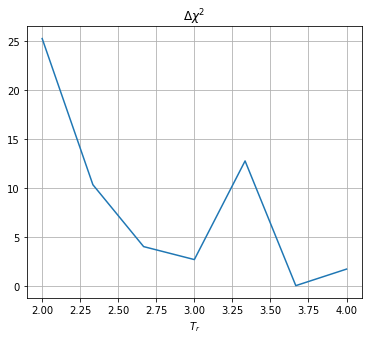

In [50]:
best   = True
trs    = np.linspace(2., 4., 7)
dpars2 = ana_trs_scan(trs, masks2)

### x-checks